In [258]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
from sklearn.metrics import r2_score
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)
pd.options.mode.chained_assignment = None  # default='warn'

In [259]:
df = ml_model.canonical_df

df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 1000)].reset_index()

df = df.loc[df.isnull().any(axis=1) == False].reset_index()
print(df.shape)
print(df.index)

(4500, 9)
RangeIndex(start=0, stop=4500, step=1)


In [260]:
#df = df.loc[df['rent_per_week'] < 1000]
#df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 100) & (df['rent_per_week'] > 100)]

df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)
df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop(['item_type'], axis = 1)
print(df.shape)
df.index


(4500, 1365)


RangeIndex(start=0, stop=4500, step=1)

In [261]:
# get list of adjective features form database
#features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

features_adj = ['tube', 'sheath', 'blouson', 'tunic', 'pencil', 'asymmetric', 'trench', 'bandage', 'high-low', 'empire',
               'bodycon', 'skater', 'maxi', 'midi', 'mini', 'kaftan', 'shirt', 'off shoulder',
               'sweater', 'tie', 'peplum', 'party', 'backless', 'fringe', 'pop', 'baby', 'a-line', 'layered', 
                'lace-up', 'denim', 'dungaree', 'pinafore', 'cape', 'fit', 'flare', 'shift', 'slit',
                'spaghetti', 't-shirt', 'tulle', 'tuxedo', 'tweed', 'wrap', 'lace', 'cocktail', 'gown', 'runway']

# take the title and one-hot it using adjectives from 'feature_adj'
#tokenized_titles = []
#for title in df['title']:
#    parse_title.create_one_hot_row_adj(title, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

# this one used both title and description
tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
            text = text_array[0]
    #parse_title.create_one_hot_row_adj(text, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [262]:
# concatenate (one-hotted brands, item types) and (adjectives)
print(df.index)
print(df_adj.shape)
df = pd.concat([df, df_adj], axis = 1)
df.shape

RangeIndex(start=0, stop=4500, step=1)
(4500, 47)


(4500, 1412)

In [293]:
#reg = RandomForestRegressor(n_jobs=2, n_estimators=20)
#clf = svm.SVR() # didn't work. Predicted 43 for everything
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .7) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
reg = linear_model.Lasso(alpha = 0.1, tol= .01)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu
#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu
#reg.fit(train[features], train['rent_per_week'])

In [264]:
# create a new column 'log_rent' which is just the log of rent
#def log_trans(x):
#    return np.log(x)

#df['log_rent'] = df['rent_per_week'].apply(log_trans)

# drop columns that we don't want to use as features in our model
excluded_features = ['rent_per_week', 'title', 'cost', 'is_train', 'description']
features = df.columns.drop(excluded_features)

# split one-hotted df into true and false subets
train, test = df[df['is_train']==True], df[df['is_train']==False]

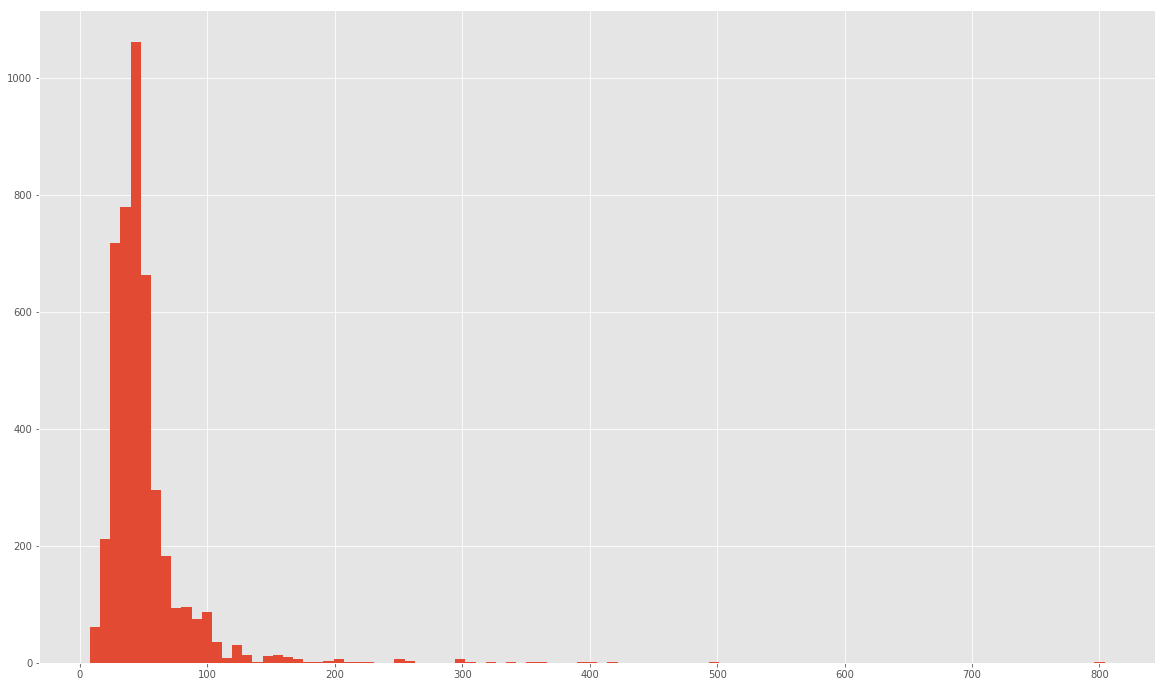

In [265]:
df['rent_per_week'].hist(bins = 100)

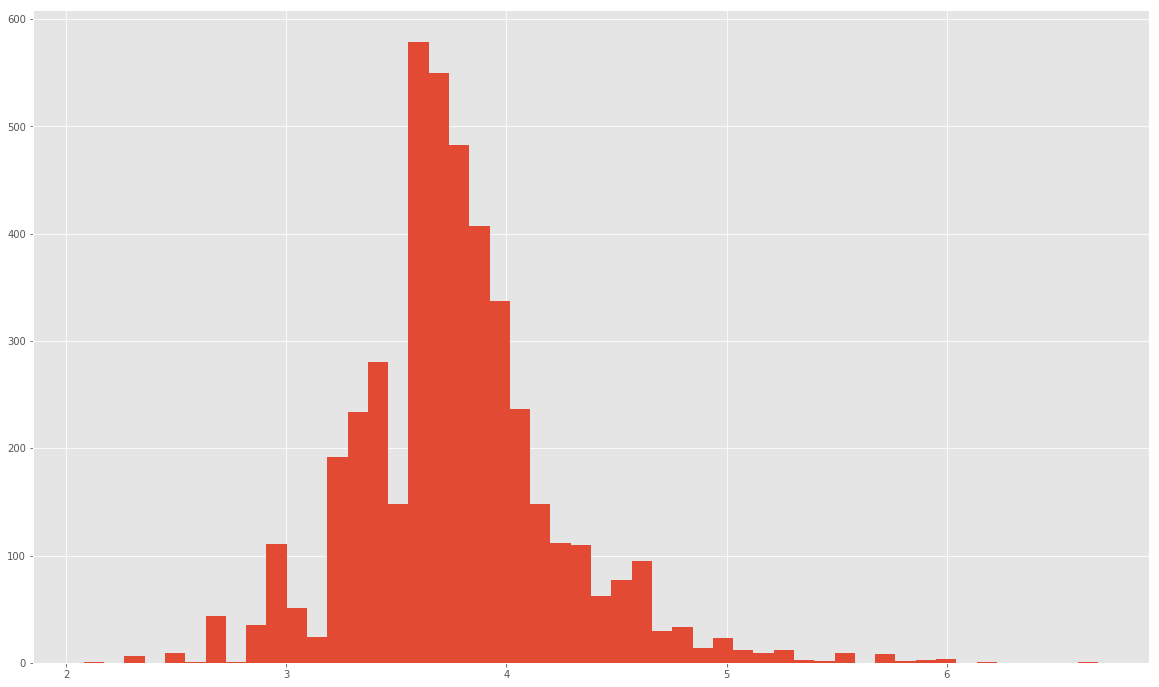

In [244]:
df['log_rent'].hist(bins = 50)

In [320]:
#reg = linear_model.Lasso(alpha = .8, tol= .8)
#reg = linear_model.Ridge(alpha = .5)
#reg = linear_model.ElasticNet(alpha=.1) # comparable to rfr 
reg = RandomForestRegressor(n_jobs=2, n_estimators=20)
reg.fit(train[features], train['rent_per_week'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

R^2: 0.025660090880999742


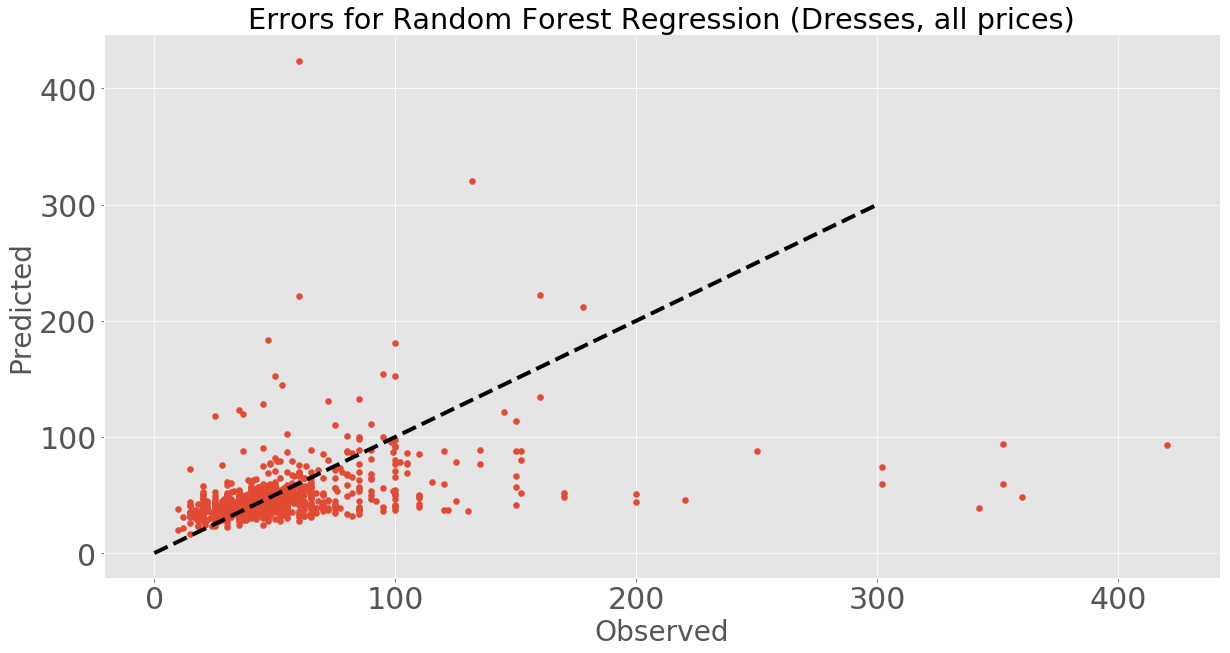

In [322]:
import matplotlib
#matplotlib.rc('xtick', labelsize=30) 
#matplotlib.rc('ytick', labelsize=30) 
matplotlib.rcParams.update({'font.size': 20})
# create model

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression (Dresses, all prices)')
ax.set_xlabel('Observed', fontsize=28)
ax.set_ylabel('Predicted', fontsize=28)
#ax.scatter(x = test['log_rent'].apply(np.exp).values, y = np.exp(predicted_log), color='#348ABD')
r2 = r2_score(test['rent_per_week'].values, reg.predict(test[features]))
print("R^2: {}".format(r2))
ax.scatter(x = test['rent_per_week'], y = reg.predict(test[features]))



In [189]:
print(r2_score(test['log_rent'].values, predicted))

-13903.7298623


In [290]:

#train['rent_per_week'].shape

0.014654874110702876

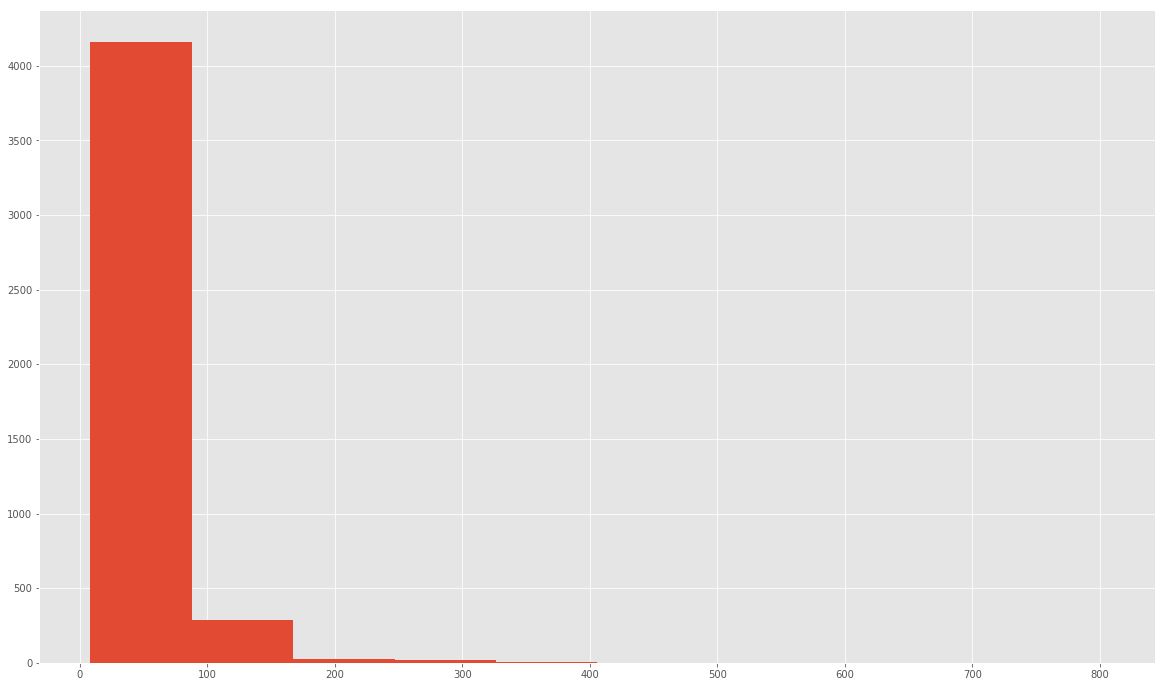

In [190]:
df['rent_per_week'].hist()

In [191]:
# saving pickled file

#model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
#model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
#joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')

Length of df_full_test: 1111


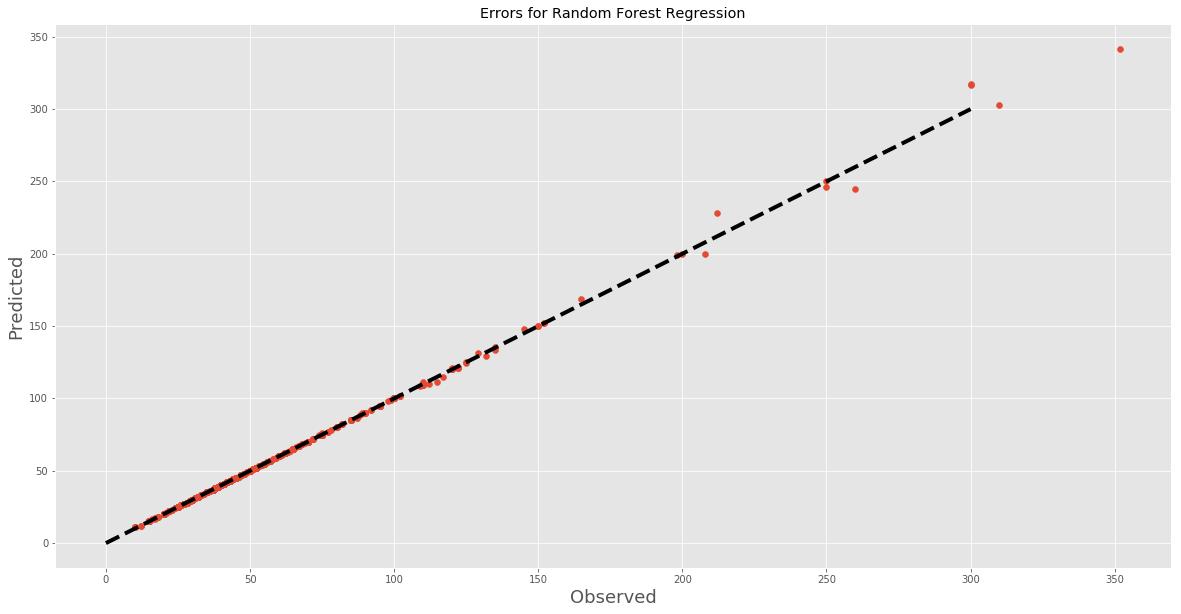

In [192]:
# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = predicted)
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
print("Length of df_full_test: {}".format(len(df_full_test)))
df_full_test['error'] = df_full_test['error'].abs()
#df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
#reg.score(x, y)
#print("Length of df_error: {}".format(len(df_error)))

In [193]:
df_full_test

,level_0,index,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
4,4,5,Adrianna Papell,dresses,Long V-Neck Beaded Gown Gunmetal,349.0,49.0,This floor sweeping gown from Adrianna Papell ...,False,49.000,0.000
5,5,6,ML Monique Lhuillier,dresses,Lace Backout Gown,798.0,89.0,This dress is perfect for your next formal occ...,False,89.600,0.600
7,7,9,For Love & Lemons,dresses,Valentina Mini Dress,292.0,45.0,"Inspired from travels to Europe, this mini was...",False,45.100,0.100
13,13,16,Bec & Bridge,dresses,Bec & Bridge Reversible Snake Charmer Dress in...,220.0,40.0,This formfitting Bec & Bridge dress may be wor...,False,40.000,0.000
15,15,18,Keepsake the Label,dresses,KEEPSAKE THE LABEL All Time High Dress,196.0,30.0,Lace trim at sweetheart neckline through cold ...,False,30.000,0.000
17,17,20,For Love & Lemons,dresses,For Love and Lemons Cosmic Midi Lace Dress,304.0,40.0,Sheer lace fabrication features tiered ruffle ...,False,40.000,0.000
20,20,23,Notte by Marchesa,dresses,glamour,1250.0,100.0,Very elegant silk dress,False,100.000,0.000
22,22,25,For Love & Lemons,dresses,Desert Mini Dress,282.0,45.0,Contrast floral embroidery and lattice trim co...,False,45.000,0.000
24,24,27,Saylor,dresses,Lexi Romper,220.0,40.0,Lattice trim and a muted tapestry print embell...,False,40.000,0.000
29,29,33,Self Portrait,dresses,Ava Guipure Lace Mini dress,421.0,65.0,\n\nThis mini dress by Self Portrait features ...,False,65.000,0.000


In [194]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_low_errors)/len(d_errors))
print(len(num_high_errors))
d_errors = df_full_test.sort_values('error', ascending=False)
d_errors

69
0.062106210621062106
0


,level_0,index,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
4054,4136,5311,Any,dresses,Prom dresses,300.00,300.0,Sexy cute beautiful and very unique,False,317.200,17.200
3093,3100,4133,patbo,dresses,patbo,3000.00,300.0,Preatty yellow dress\nVery fancy,False,316.800,16.800
3659,3722,4864,Ines Richards,dresses,Paradise Azul,2000.00,212.0,Beautifully custom made and had stitched gown from the Dominican Republic. Soft tulle ruffle create a full skirt forming an hourglass shape form. Teal blue strapless gown featured with matching lace overlay and waist belt.,False,228.000,16.000
430,430,514,FAUSTO PUGLISI,dresses,Deep V-neck Side Slit Gown,3024.76,260.0,"This blue deep v-neck side slit gown from Fausto Puglisi features a back zipper, a side slit, and long sleeves. \n\nBrand New.",False,245.000,15.000
4498,4583,5760,Yves Saint Laurent,dresses,Yves Saint Laurent,3500.00,352.0,Convertible 100% silk matte Jersey dress that one can wear as seen here with a halter style and sexy side slit or also as a one-shoulder asymmetrical dress. Grecian style with beautiful draping. Tags are still intact. Be the first one to ever wear it / rent it.,False,341.600,10.400
3632,3692,4832,Jason Wu,dresses,Woo Me,2500.00,208.0,"This dress perfectly combines lace and leather, pushing just enough boundaries. Perfect for a cocktail event or date night, pair this dress with black booties and enjoy your favorite cocktails and company in killer style. Composition: 65% Cotton, 35% Polyamide",False,200.000,8.000
3913,3995,5161,Zac Posen,dresses,Gorgeous Orange Runway Gown,8000.00,310.0,"Luxurious and opulent, adorn yourself with this warm copper-toned gown. Cut in a signature Zac Posen design, it is perfectly form-fitting, comfortable, and surprisingly easy to walk/dance in. This gown will be sure to make you stand out.",False,302.800,7.200
2235,2235,2839,Herve Leger,dresses,Black Mesh Beaded Gown,4500.00,250.0,"Long black form fitting mesh gown with criss cross one shoulder straps, corseted bodice, side zip closure, and beaded detailing throughout. This gown has been hemmed a couple inches, please refer to measurements. \n\nComposition: Unknown\nSize: XS\nLength: 49.75""\nBust: 14.5""\nWaist: 25""\nHips: 30""",False,246.000,4.000
452,452,537,BALMAIN,dresses,Mesh Panel Dress,2425.65,165.0,"This nude Mesh Panel Dress from Balmain features a round neck, long sleeves, cut out details, mesh panels, and a bodycon style.Outer Composition:Spandex/Elastane 1%. Outer Composition:Viscose 86%. Outer Composition:Polyamide 13%.\n\nBrand New. You would be the first to wear it.",False,168.800,3.800
2237,2237,2842,BCBGMAXAZRIA,dresses,Blue Pleated Lace Gown,468.00,115.0,"The perfect, sophisticated pleated gown from BCBGMAXAZRIA. Pair it with classic accessories for a polished look. Blue chiffon, lace cutouts, hidden back zipper. Size 10. Fits true to size.",False,111.600,3.400


In [195]:
df_error[df_error['brand']=='Yves Saint Laurent']

NameError: name 'df_error' is not defined

In [ ]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

In [ ]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

['dresses', 'bottoms', 'shoes', 'accessories', 'tops', 'outerwear', 'bags', 'other']
[5089, 254, 254, 240, 196, 120, 89, 26]


/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


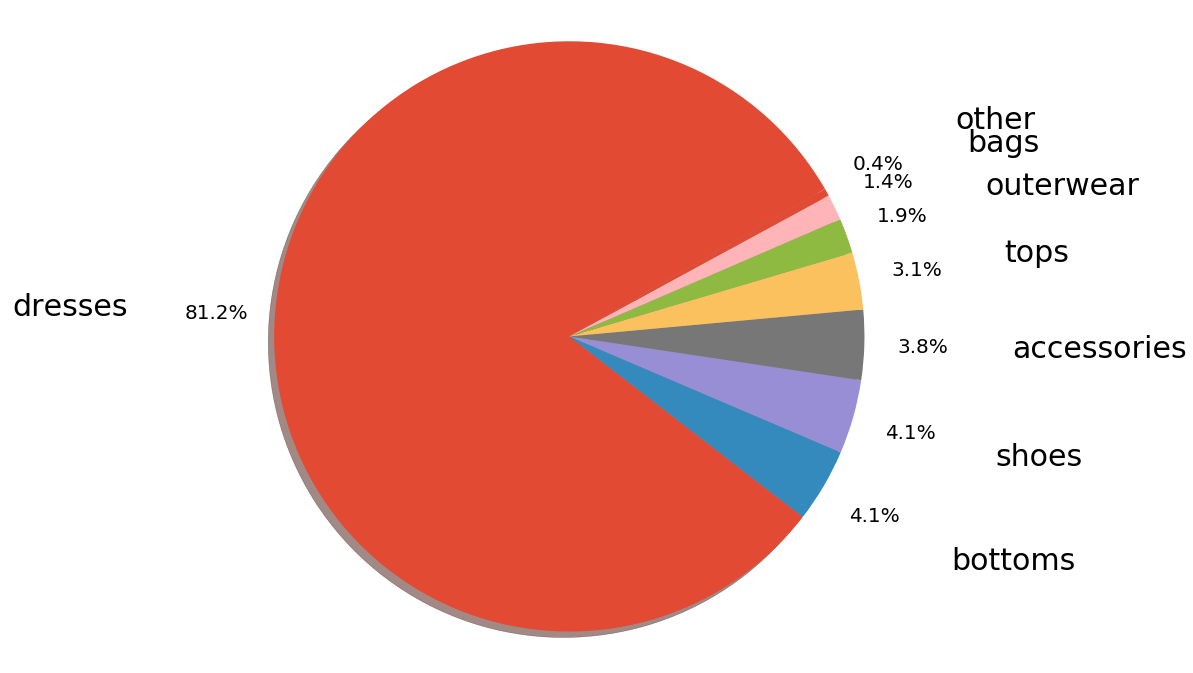

In [407]:
query = "SELECT DISTINCT item_type, count(item_type) FROM items GROUP BY item_type ORDER BY count(item_type) DESC;"
from wombat.models import engine
res = engine.execute(query).fetchall()
labels = [r[0] for r in res[0:7]] + ['other']
counts = [r[1] for r in res[0:7]] + [26]
print(labels)
print(counts)

fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=30, pctdistance = 1.2, labeldistance = 1.5)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.legend(counts, labels=labels, loc='best')
plt.show()